# Importing and Pre-processing Data

In [ ]:
#import Required Modules

import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from pathlib import Path
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#defining some constant values

BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=20

In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(     #load the image from the directory
    "/content/drive/MyDrive/Dataset_BUSI_with_GT",                 #name of the dataset
    seed=123,
    shuffle=True,                                                  #Shuffle the images randomly
    image_size=(IMAGE_SIZE,IMAGE_SIZE),                            #calling the image size
    batch_size=BATCH_SIZE                                          #calling the bacth size
)

Found 1765 files belonging to 3 classes.


In [ ]:
#find the name of three class

class_names = dataset.class_names
class_names

['benign', 'malignant', 'normal']

In [ ]:
for image_batch, label_batch in dataset.take(1): #here take one batch to find the batch size, image size, rgb channel value
    print(image_batch.shape)
    print(label_batch.numpy())                   #display in numpy array

# labels of the class
# 0=angular_leaf_spot, 1=bean_rust, 2=healthy

(32, 256, 256, 3)
[0 0 2 1 0 1 0 0 1 0 1 0 1 0 0 0 0 0 2 0 0 2 2 2 1 1 2 1 0 1 1 0]


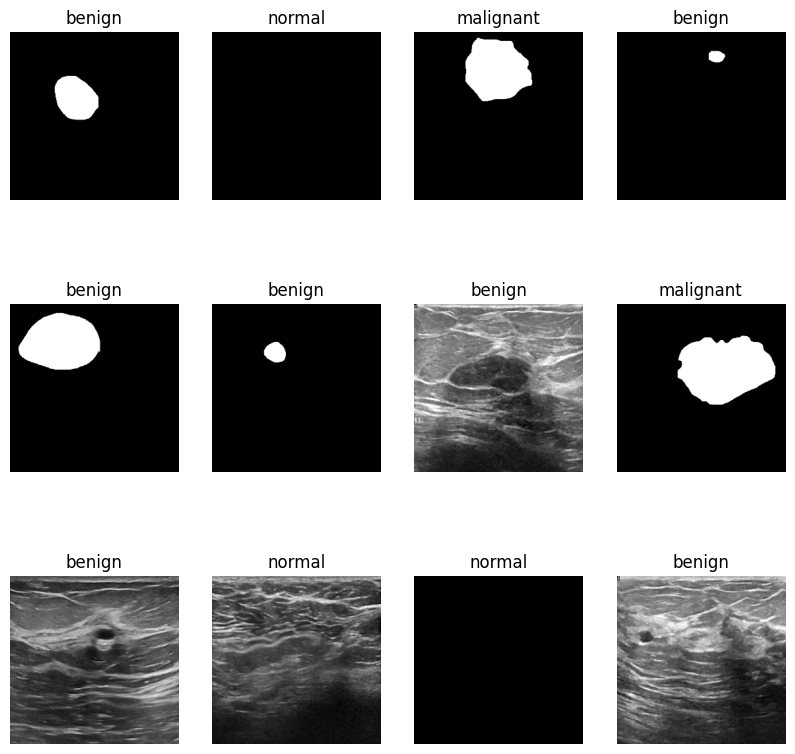

In [ ]:
#display 12 images
plt.figure(figsize=(10, 10))  #image dimension in subplot

for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i+1)  #create subplot of 3*4 matrix
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

# Train-Test Split

In [ ]:
# Here 80% of data is used for Training
# 10% = validation
# 10% = testing

In [ ]:
len(dataset) #length of the dataset after batching here all batch = 32 files

56

In [ ]:
#A simple code for train test split using a function

def get_dataset_partition_tf(ds, train_split=0.8, test_split=0.1, val_split=0.1, shuffle=True, shuffle_size=10000):

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, test_ds, val_ds


In [ ]:
train_ds, val_ds, test_ds = get_dataset_partition_tf(dataset)

In [ ]:
print("Length of Dataset: ",len(dataset))
print("Train Split: ",len(train_ds))
print("Test Split: ",len(test_ds))
print("Validation Split: ",len(val_ds))

Length of Dataset:  56
Train Split:  44
Test Split:  5
Validation Split:  7


# Catch, Prefetch and Shuffle data

In [ ]:
# This is basically done to make the model to perform better the system
# "Cache" will cache the dataset and store it in memory during one epoch and it will reuse the data for next epoch
# "Prefetch" will load the next data when the 1st training is performing. This will save the time.
# Here buffer_size is automatically done by tensor

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

# Here the Data is optimized for training

In [ ]:
#Image resizing and rescaling
#This is one of the Layer of Model

rescale_and_resize = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE), #Img is resize when a input img is not in the required size during the use of app
    layers.experimental.preprocessing.Rescaling(1.0/255) #Rescaling is done reduce the numpy array of RGB value to 0 to 1
])

In [ ]:
# This is done to Augment the image for better performence when the input is in any form

data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

# Model Building

In [ ]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    rescale_and_resize,  #adding this layer
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape = input_shape), #32=filters
    layers.MaxPooling2D((2,2)),   #perform pooling
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),    #flatten the last pooling layer
    layers.Dense(64, activation='relu'),  #relu is an activation which is used for better performance
    layers.Dense(n_classes, activation='softmax'), #softmax normalize the probability of the classes
])

model.build(input_shape = input_shape)


In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

# Model Training

In [ ]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS
)
model.save("/content/drive/MyDrive/out.h5")

Epoch 1/20
44/44 [==============================] - 268s 3s/step - loss: 0.8992 - accuracy: 0.5320 - val_loss: 0.8282 - val_accuracy: 0.5491
Epoch 2/20
44/44 [==============================] - 111s 3s/step - loss: 0.7851 - accuracy: 0.5795 - val_loss: 0.7478 - val_accuracy: 0.5804
Epoch 3/20
44/44 [==============================] - 107s 2s/step - loss: 0.7298 - accuracy: 0.6911 - val_loss: 0.7388 - val_accuracy: 0.6652
Epoch 4/20
44/44 [==============================] - 105s 2s/step - loss: 0.6605 - accuracy: 0.6989 - val_loss: 0.6571 - val_accuracy: 0.7232
Epoch 5/20
44/44 [==============================] - 106s 2s/step - loss: 0.5594 - accuracy: 0.7443 - val_loss: 0.5007 - val_accuracy: 0.7589
Epoch 6/20
44/44 [==============================] - 112s 3s/step - loss: 0.4817 - accuracy: 0.7791 - val_loss: 0.4396 - val_accuracy: 0.8080
Epoch 7/20
44/44 [==============================] - 108s 2s/step - loss: 0.4768 - accuracy: 0.7884 - val_loss: 0.4311 - val_accuracy: 0.8259
Epoch 8/20
44

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
scores = model.evaluate(test_ds)

5/5 [==============================] - 12s 667ms/step - loss: 0.1928 - accuracy: 0.9624


In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

NameError: name 'plt' is not defined

# Model Prediction

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 40ms/step


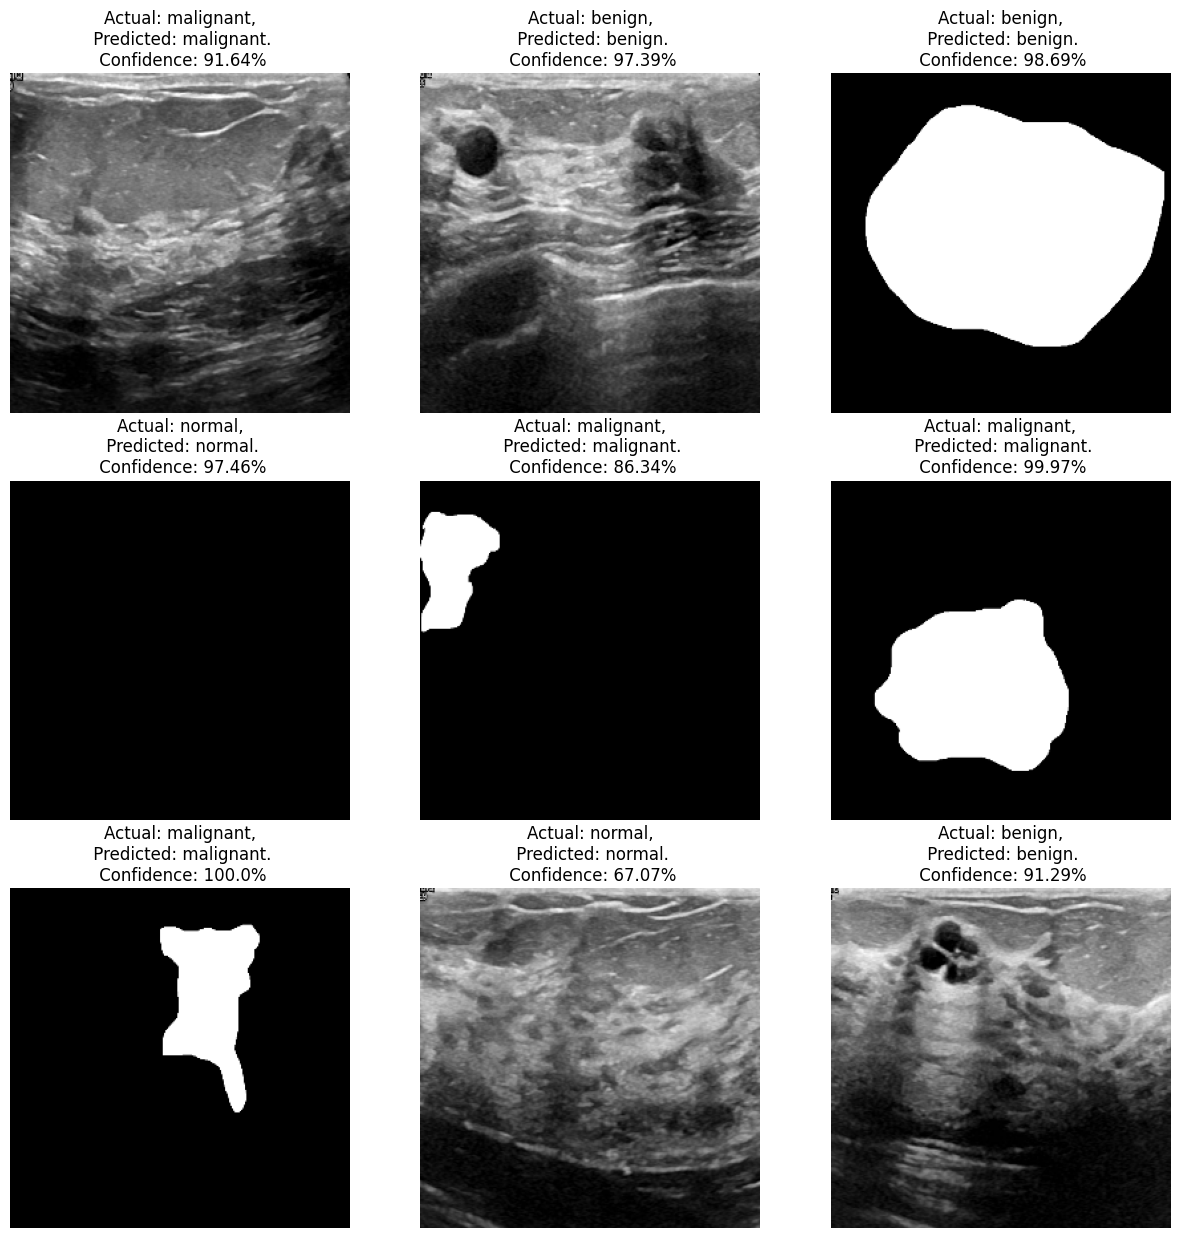

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

# Model Evaluation

In [ ]:
#perform prediction on test data
y_pred = model.predict(test_ds)

5/5 [==============================] - 3s 505ms/step


In [ ]:
#get the prediction values from test data
predicted_categories = tf.argmax(y_pred, axis=1)
predicted_categories

<tf.Tensor: shape=(133,), dtype=int64, numpy=
array([0, 1, 1, 2, 0, 1, 0, 1, 1, 0, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2,
       0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 2, 1, 1, 1, 2, 0, 2, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1,
       0, 1, 0, 2, 2, 2, 2, 1, 0, 1, 0, 2, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1,
       0, 2, 0, 2, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 2, 1, 0,
       0, 1, 1, 0, 1, 0, 1, 2, 0, 2, 1, 1, 2, 1, 0, 0, 2, 0, 0, 0, 1, 1,
       0])>

In [ ]:
#get the actual values from test data
true_categories = tf.concat([y for x, y in test_ds], axis=0)
true_categories

<tf.Tensor: shape=(133,), dtype=int32, numpy=
array([0, 0, 0, 0, 0, 1, 2, 1, 0, 2, 0, 1, 0, 1, 0, 1, 2, 0, 2, 1, 1, 2,
       1, 0, 0, 2, 0, 0, 0, 1, 1, 0, 2, 2, 2, 2, 1, 0, 1, 0, 2, 0, 2, 0,
       0, 0, 0, 1, 1, 0, 1, 0, 2, 0, 2, 1, 0, 0, 0, 0, 0, 2, 0, 1, 0, 0,
       1, 2, 0, 1, 0, 1, 1, 0, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 1,
       0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 2, 1, 1, 1, 2, 0, 2, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1,
       0], dtype=int32)>

In [ ]:
#evaluate the model

def evaluate_model(model, test_ds):

    results = model.evaluate(test_ds, verbose=0)
    loss = results[0]
    acc = results[1]

    print("Test Loss    : {:.5f}".format(loss))  #print test loss
    print("Test Accuracy: {:.2f}%".format(acc * 100))  #print test accuracy

    clr = classification_report(true_categories, predicted_categories, target_names=["Benign", "Malignant","Normal"])


    print("Classification Report:\n----------------------\n", clr)

In [ ]:
evaluate_model(model, test_ds)

Test Loss    : 0.19277
Test Accuracy: 96.24%
Classification Report:
----------------------
               precision    recall  f1-score   support

      Benign       0.56      0.56      0.56        72
   Malignant       0.37      0.39      0.38        38
      Normal       0.10      0.09      0.09        23

    accuracy                           0.43       133
   macro avg       0.34      0.35      0.34       133
weighted avg       0.42      0.43      0.43       133

